<a href="https://colab.research.google.com/github/ruhanaazam/gp_transfer/blob/main/MixedKernelTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!cd drive

In [ ]:
# !pip install gpytorch
# !pip install botorch

In [ ]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import gpytorch
from botorch.utils.transforms import normalize, standardize
import matplotlib.pyplot as plt

from botorch import fit_gpytorch_model
from botorch.models import SingleTaskGP, MixedSingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models.transforms import Standardize, Normalize
from botorch.fit import fit_gpytorch_mll

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def surfacePlot(model, title = "Your Function" ,n=900):
    '''
    Plots your (true or estimated) coheritability function.
    model: function that takes in two wavelength and outputs coh2 (estimate)
    n: n**2 is the number of points to plot the surface
    '''
    # Generate data for the plot
    x1 = torch.linspace(0, 1, n)
    x2 = torch.linspace(0, 1, n)
    X1, X2 = torch.meshgrid(x1, x2)
    X = torch.stack([X1.reshape((-1)),X2.reshape((-1))]).T

    Z = model(X.to(device)).cpu().detach().numpy()

    # Create a contour plot
    plt.contourf(X1, X2, Z.reshape(n, n), cmap='viridis')
    plt.colorbar(label='Function Value')

    #plot top 1%
    #threshold = np.percentile(Z, 99)
    #threshold = torch.kthvalue(Z.flatten(), int(0.99 * n * n)).values
    #plt.contour(X1, X2, Z.reshape(n, n), levels=[threshold], colors='red', linewidths=2)

    # Add labels and title
    plt.xlabel('Wavelength 1')
    plt.ylabel('Wavelength 2')
    plt.title(title)

    # Show the plot
    plt.show()
    return

In [ ]:
def getTaskID(trait, crop="Sorghum"):
    assert crop == "Sorghum", "Does not handles ids for from that are not Sorghum yet."
    ids = {"narea": 1, "sla": 2, "pn": 3, "ps": 4}
    return ids[trait]

In [ ]:
def loadTasks(tasks):
    taskData = []
    for trait in tasks:
        #read raw task file
        data = pd.read_csv(f"/content/drive/My Drive/Colab Notebooks/Transfer_Coh2/data/{trait}_coh2.csv")
        data = torch.tensor(data.values)

        #format data for supervised training, each row (taskid, wave1, wave2, coh2)
        n = torch.ones(data.shape[0], dtype=torch.float32)
        col_index =  torch.arange(data.shape[0], dtype=torch.float32)
        col_index = torch.outer(n, col_index)
        row_index = col_index.T

        #stack wave1, wave2 and coh2 tensors together
        task_ids = torch.ones(data.shape) * getTaskID(trait)
        flat_data = torch.stack([task_ids.flatten(), col_index.flatten(), row_index.flatten(), data.flatten()])
        flat_data = flat_data.T

        #remove all rows with nans
        nan_mask = torch.isnan(flat_data)
        nan_in_rows = torch.any(nan_mask, dim=1)
        clean = flat_data[~nan_in_rows]

        taskData.append(clean)

    #combine all tasks
    all_tasks = torch.cat(taskData)
    return all_tasks[:, :3], all_tasks[:, -1]

In [ ]:
#Load data (by tasks)
X, Y = loadTasks(["narea", "sla", "pn", "ps"])

#Split into train and validation sets
seed = 1234
split = 1
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=split, random_state=seed)

# Convert NumPy arrays to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float64)
y_train = torch.tensor(y_train, dtype=torch.float64)
x_test = torch.tensor(x_test, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64)

<ipython-input-8-8711f4cb8d26>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float64)
<ipython-input-8-8711f4cb8d26>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float64)
<ipython-input-8-8711f4cb8d26>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float64)
<ipython-input-8-8711f4cb8d26>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourc

In [ ]:
from botorch.utils.transforms import normalize, standardize
#subsection of data
N = 3000
x_train = x_train[:N, ]#1:] #remove task feature
y_train = y_train [:N]

In [ ]:
d_xtrain = x_train[:,0].reshape(-1,1) #discrete part
c_xtrain = normalize(x_train[:, 1:], torch.tensor([[0,0],[2150,2150]])) #continous part
x_train_normalized = torch.cat([c_xtrain, d_xtrain], dim=1)
y_train_standardized = standardize(y_train).reshape(-1,1)

#model = SingleTaskGP(c_xtrain, y_train.reshape(-1,1))
model = MixedSingleTaskGP(x_train_normalized, y_train_standardized, cat_dims=[-1])

# Use Exact Marginal Log Likelihood as the loss
mll = ExactMarginalLogLikelihood(model.likelihood, model)

# Fit the model
fit_gpytorch_mll(mll, )

#get gaussian likelihood then it has object noise
#refer: https://docs.gpytorch.ai/en/stable/likelihoods.html
print(f"noise: {model.likelihood.noise.item()}")

#Get the lengthscale
#kernel = model.covar_module.base_kernel
#print(f"lengthscale: {kernel.lengthscale.detach()}")
print(model.covar_module)

/usr/local/lib/python3.10/dist-packages/botorch/models/utils/assorted.py:174: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


noise: 9.999999974752427e-07
AdditiveKernel(
  (kernels): ModuleList(
    (0): ScaleKernel(
      (base_kernel): AdditiveKernel(
        (kernels): ModuleList(
          (0): MaternKernel(
            (raw_lengthscale_constraint): GreaterThan(1.000E-04)
          )
          (1): ScaleKernel(
            (base_kernel): CategoricalKernel(
              (raw_lengthscale_constraint): GreaterThan(1.000E-06)
            )
            (raw_outputscale_constraint): Positive()
          )
        )
      )
      (raw_outputscale_constraint): Positive()
    )
    (1): ScaleKernel(
      (base_kernel): ProductKernel(
        (kernels): ModuleList(
          (0): MaternKernel(
            (raw_lengthscale_constraint): GreaterThan(1.000E-04)
          )
          (1): CategoricalKernel(
            (raw_lengthscale_constraint): GreaterThan(1.000E-06)
          )
        )
      )
      (raw_outputscale_constraint): Positive()
    )
  )
)


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


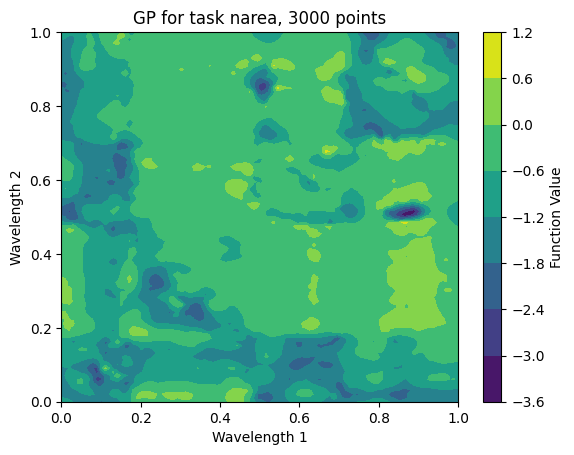

In [ ]:
task = "narea"

def modelWrapper(X):
  id = getTaskID(task)
  id_vector = id * torch.ones((X.shape[0],1))
  inp = torch.cat([X, id_vector], dim=1)
  return model.posterior(inp).mean

surfacePlot(modelWrapper, title=f"GP for task {task}, {len(x_train)} points", n=100)

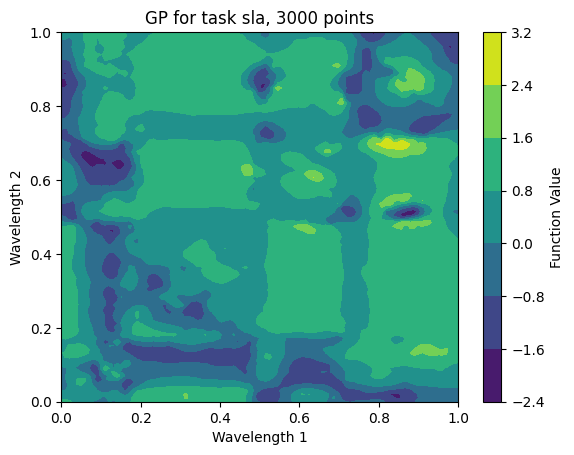

In [ ]:
task = "sla"

def modelWrapper(X):
  id = getTaskID(task)
  id_vector = id * torch.ones((X.shape[0],1))
  inp = torch.cat([X, id_vector], dim=1)
  return model.posterior(inp).mean

surfacePlot(modelWrapper, title=f"GP for task {task}, {len(x_train)} points", n=100)

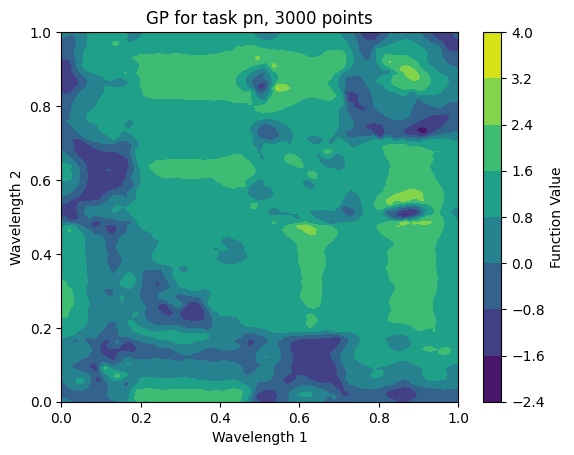

In [ ]:
task = "pn"

def modelWrapper(X):
  id = getTaskID(task)
  id_vector = id * torch.ones((X.shape[0],1))
  inp = torch.cat([X, id_vector], dim=1)
  return model.posterior(inp).mean

surfacePlot(modelWrapper, title=f"GP for task {task}, {len(x_train)} points", n=100)

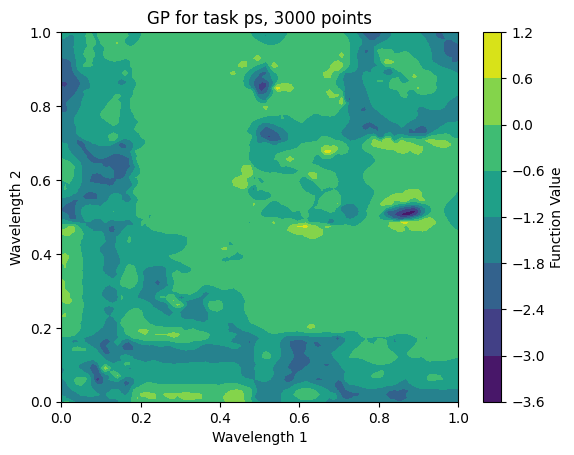

In [ ]:
task = "ps"

def modelWrapper(X):
  id = getTaskID(task)
  id_vector = id * torch.ones((X.shape[0],1))
  inp = torch.cat([X, id_vector], dim=1)
  return model.posterior(inp).mean

surfacePlot(modelWrapper, title=f"GP for task {task}, {len(x_train)} points", n=100)